In [1]:
import torch as th
from time import time
from params import default_params, set_tsp_params

# ------------------------- SET DEFAULT DEVICE -------------------
params = default_params()
params['device'] = "cuda" if th.cuda.is_available() else "cpu"
print("Device in use: ", params['device'])
th.device(params['device'])
# ----------------------------------------------------------------

# ------------------------- ENVIRONMENTS ---------------------------
from environments.environment_tsp import EnviornmentTSP
# ----------------------------------------------------------------

# ------------------------- NETWORKS -------------------------------
from networks.basic_network import BasicNetwork
from networks.more_basic_net import MoreBasicNetwork
from networks.embedder_network import EmbedderNetwork
from networks.transformer import Transformer
# ----------------------------------------------------------------

# ------------------------- EXPERIMENTS ----------------------------
from experiments.actor_critic_experiment import ActorCriticExperiment
# ----------------------------------------------------------------

# ------------------------- CONTROLLERS ----------------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.ppo_learner import PPOLearner
from learners.actor_critic_learner import ActorCriticLearner
# ------------------------------------------------------------------

from generators.tsp_generator import TSPGenerator
from exact_solvers.solver_tsp import solve_tsp

/home/tomas/miniconda3/envs/attention_tsp/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Device in use:  cpu


In [2]:
max_nodes_per_graph = 10
rollouts_per_batch = 50
pct_epsilon_anneal_time = 0.75
max_episodes = 3000

# Problem parameters
params['problem'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['max_episodes'] = max_episodes

# Batch parameters
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch

# Learning parameters
params['lr'] = 5E-4
params['gamma'] = 0.99

# Regularization parameters
params['entropy_regularization'] = True
params['entropy_weight'] = 0.1

# Parallelism parameters
params['multi_runner'] = False               
params['parallel_environments'] = 4    

# Bias parameters
params['advantage_bias'] = True
params['value_targets'] = 'td'

# Actor critic parameters
params['advantage_bootstrap'] = True

# Off policy parameters
params['offpolicy_iterations'] = 10

# PPO parameters
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

# Epsilon parameters
params['epsilon_start'] = 1.0
params['epsilon_finish'] = 1E-5
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['epsilon_decay'] = "exponential"

# Environment parameters
params['diff_sizes'] = True
params['diff_cities'] = True
params['training_sizes'] = [5, max_nodes_per_graph]
params['num_train_instance_per_size'] = 10

# Network parameters
params['num_heads']: 4              
params['num_layers']: 3                 
params['normalization']: 'batch'     
params['feed_forward_hidden']: 512      
params['embed_dim']: 4
    
# Others
params['plot_frequency'] = 10

print("Epsilon anneal time: ", params['epsilon_anneal_time'])
print("Total transitions: ", params['max_steps'])

Epsilon anneal time:  1237500.0
Total transitions:  1650000


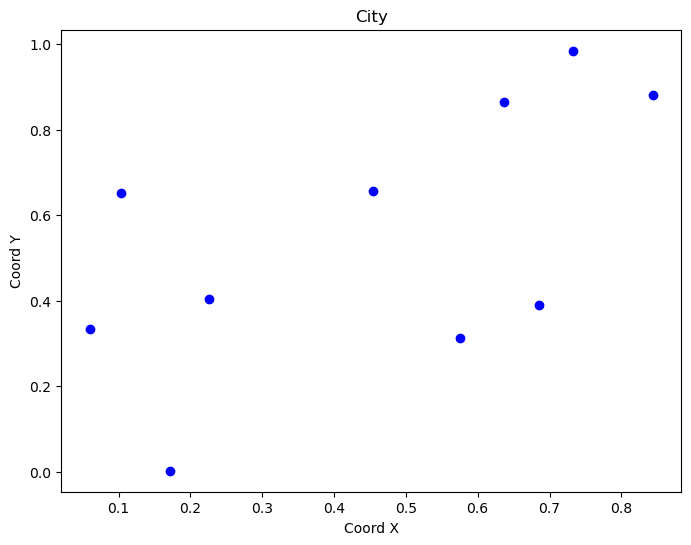

Distance:  tensor(2.9009)


In [3]:
nodes_per_graph = 10
instance = 0
cities = th.load(f"training/tsp/size_{nodes_per_graph}/instance_{instance}.pt")
#cities = cities.to(params['device'])
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(cities)
permutation, distance = solve_tsp(cities)
print("Distance: ", distance)

In [4]:
cum_dist = 0
for i in range(10):
    avg_cities = th.load(f"training/tsp/size_{nodes_per_graph}/instance_{i}.pt")
    permutation, distance = solve_tsp(avg_cities)
    cum_dist += distance
print(f"Average distance: {cum_dist/10}")

Average distance: 2.7724297046661377


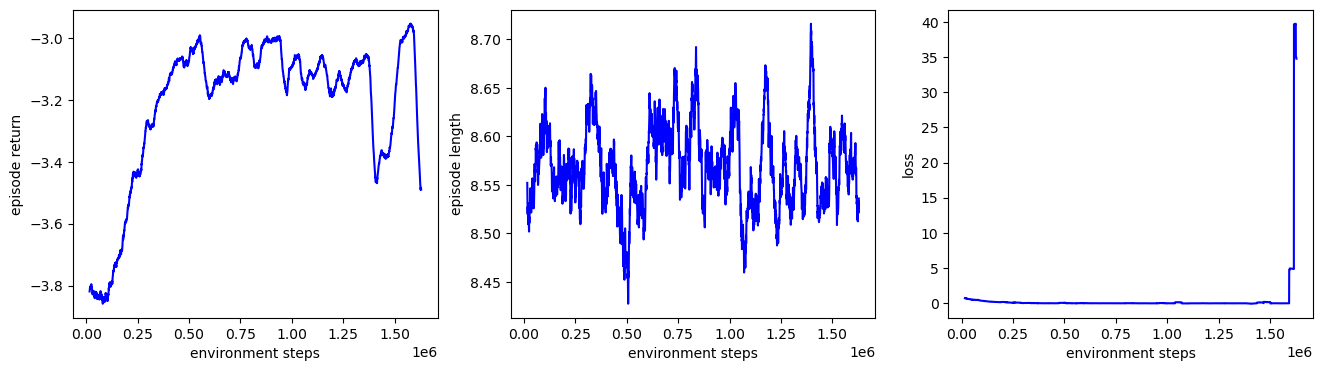

Total spended time in experiment:  7741.732531547546


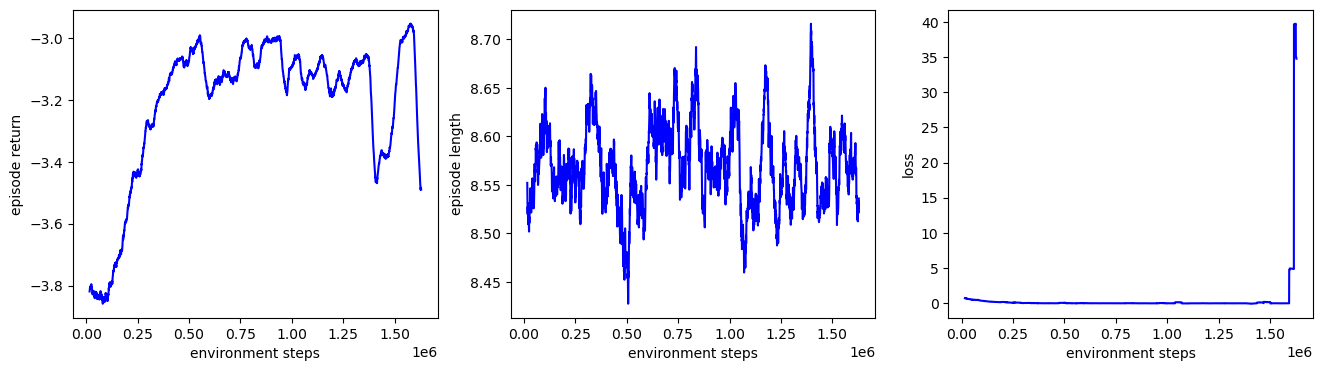

In [5]:
model = Transformer(params=params)
env = EnviornmentTSP(params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, PPOLearner(model=model, params=params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

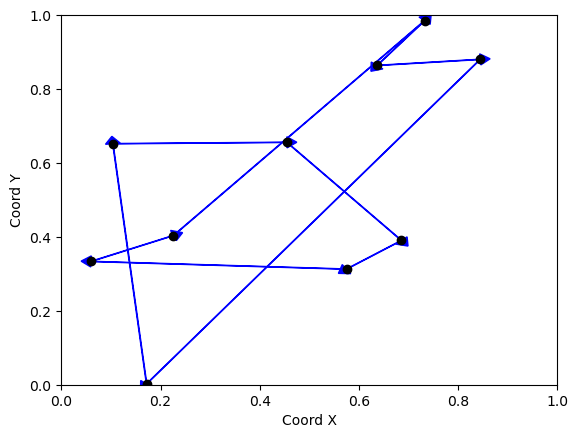

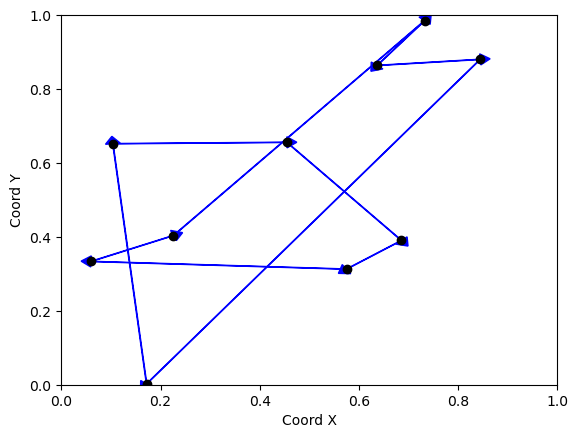

In [26]:
experiment.plot_rollout()